![NYCTaxiTripForecasting](img/NYCTaxi.jpg)

# <center>Проект 5: Предсказание продолжительности поездки на такси в Нью-Йорке</center>  

## 1. Постановка задачи  

Вам предстоит решить настоящую задачу машинного обучения, направленную на автоматизацию бизнес процессов. Мы построим модель, которая будет предсказывать общую продолжительность поездки такси в Нью-Йорке. 

Представьте вы заказываете такси из одной точки Нью-Йорка в другую, причем не обязательно конечная точка должна находиться в пределах города. Сколько вы должны будете за нее заплатить? Известно, что стоимость такси в США  рассчитывается на основе фиксированной ставки + тарифная стоимость, величина которой зависит от времени и расстояния. Тарифы варьируются в зависимости от города.

В свою очередь время поездки зависит от множества факторов таких как, откуда и куда вы едете, в какое время суток вы совершаете вашу поездку, погодных условий и так далее. 

Таким образом, если мы разработаем алгоритм, способный определять длительность поездки, мы сможем прогнозировать ее стоимость самым тривиальным образом, например, просто умножая стоимость на заданный тариф. 
Сервисы такси хранят огромные объёмы информации о поездках, включая такие данные как конечная, начальная точка маршрута, дата поездки и ее длительность. Эти данные можно использовать для того, чтобы прогнозировать длительность поездки в автоматическом режиме с привлечением искусственного интеллекта.

**Бизнес-задача:** определить характеристики и с их помощью спрогнозировать длительность поездки такси.

**Техническая задача для вас как для специалиста в Data Science:** построить модель машинного обучения, которая на основе предложенных характеристик клиента будет предсказывать числовой признак - время поездки такси. То есть решить задачу регрессии.

**Основные цели проекта:**
1. Сформировать набор данных на основе нескольких источников информации
2. Спроектировать новые признаки с помощью Feature Engineering и выявить наиболее значимые при построении модели
3. Исследовать предоставленные данные и выявить закономерности
4. Построить несколько моделей и выбрать из них наилучшую по заданной метрике
5. Спроектировать процесс предсказания времени длительности поездки для новых данных

Загрузить свое решение на платформу Kaggle, тем самым поучаствовав в настоящем Data Science соревновании.
Во время выполнения проекта вы отработаете навыки работы с несколькими источниками данных, генерации признаков, разведывательного анализа и визуализации данных, отбора признаков и, конечно же, построения моделей машинного обучения!


## 2. Знакомство с данными, базовый анализ и расширение данных

Начнём наше исследование со знакомства с предоставленными данными. А также подгрузим дополнительные источники данных и расширим наш исходный датасет. 


Заранее импортируем модули, которые нам понадобятся для решения задачи:

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from scipy import stats
from sklearn import linear_model
from sklearn import preprocessing
from sklearn import model_selection
from sklearn import tree
from sklearn import ensemble
from sklearn import metrics
from sklearn import cluster
from sklearn.feature_selection import SelectKBest, f_regression

Прочитаем наш файл с исходными данными:

In [2]:
DATA_DIR = '/kaggle/input/'

In [3]:
taxi_data = pd.read_csv(DATA_DIR+'nyc-taxi-trip-duration/train.zip')
print('Train data shape: {}'.format(taxi_data.shape))
taxi_data.head()

Train data shape: (1458644, 11)


,id,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,trip_duration
0,id2875421,2,2016-03-14 17:24:55,2016-03-14 17:32:30,1,-73.982155,40.767937,-73.964630,40.765602,N,455
1,id2377394,1,2016-06-12 00:43:35,2016-06-12 00:54:38,1,-73.980415,40.738564,-73.999481,40.731152,N,663
2,id3858529,2,2016-01-19 11:35:24,2016-01-19 12:10:48,1,-73.979027,40.763939,-74.005333,40.710087,N,2124
3,id3504673,2,2016-04-06 19:32:31,2016-04-06 19:39:40,1,-74.010040,40.719971,-74.012268,40.706718,N,429
4,id2181028,2,2016-03-26 13:30:55,2016-03-26 13:38:10,1,-73.973053,40.793209,-73.972923,40.782520,N,435


Итак, у нас с вами есть данные о почти 1.5 миллионах поездок и 11 характеристиках, которые описывают каждую из поездок. 

Мы условно разделили признаки на несколько групп. Каждой из групп мы в дальнейшем уделим отдельное внимание.

**Данные о клиенте и таксопарке:**
* id - уникальный идентификатор поездки
* vendor_id - уникальный идентификатор поставщика (таксопарка), связанного с записью поездки

**Временные характеристики:**
* pickup_datetime - дата и время, когда был включен счетчик поездки
* dropoff_datetime - дата и время, когда счетчик был отключен

**Географическая информация:**
* pickup_longitude -  долгота, на которой был включен счетчик
* pickup_latitude - широта, на которой был включен счетчик
* dropoff_longitude - долгота, на которой счетчик был отключен
* dropoff_latitude - широта, на которой счетчик был отключен

**Прочие признаки:**
* passenger_count - количество пассажиров в транспортном средстве (введенное водителем значение)
* store_and_fwd_flag - флаг, который указывает, сохранилась ли запись о поездке в памяти транспортного средства перед отправкой поставщику. Y - хранить и пересылать, N - не хранить и не пересылать поездку.

**Целевой признак:**
* trip_duration - продолжительность поездки в секундах


Для начала мы проведем базовый анализ того, насколько данные готовы к дальнейшей предобработке и анализу. 

### Задание 2.1
Для начала посмотрим на временные рамки, в которых мы работаем с данными.

Переведите признак pickup_datetime в тип данных datetime с форматом год-месяц-день час:минута:секунда (в функции pd.to_datetime() параметр format='%Y-%m-%d %H:%M:%S'). 

Определите временные рамки (без учета времени), за которые представлены данные.

In [4]:
taxi_data['pickup_datetime'] = pd.to_datetime(taxi_data['pickup_datetime'], format='%Y-%m-%d %H:%M:%S')
first_date = taxi_data['pickup_datetime'].dt.date.min()
last_date = taxi_data['pickup_datetime'].dt.date.max()
date_period = (last_date - first_date).days
print(f'Данные предоставлены за {date_period} день: с {first_date} по {last_date}.')

Данные предоставлены за 181 день: с 2016-01-01 по 2016-06-30.


### Задание 2.2
Посмотрим на пропуски. 
Сколько пропущенных значений присутствует в данных (суммарно по всем столбцам таблицы)?

In [5]:
print('Общее число пропущенных значений:', taxi_data.isna().sum().sum())

Общее число пропущенных значений: 0


### Задание 2.3
Посмотрим на статистические характеристики некоторых признаков. 

а) Сколько уникальных таксопарков присутствует в данных?

б) Каково максимальное количество пассажиров?

в) Чему равна средняя и медианная длительность поездки? Ответ приведите в секундах и округлите до целого.

г) Чему равно минимальное и максимальное время поездки (в секундах)?


In [6]:
# Для ответа на поставленные вопросы метод describe не очень подойдет
print('Количество уникальных таксопарков:', taxi_data['vendor_id'].nunique())
print('Максимальное количество пассажиров:', taxi_data['passenger_count'].max())
print('Среднее время поездки (сек.):', round(taxi_data['trip_duration'].mean()))
print('Медианное время поездки (сек.):', round(taxi_data['trip_duration'].median()))
print('Минимальное время поездки (сек.):', round(taxi_data['trip_duration'].min()))
print('Максимальное время поездки (сек.):', round(taxi_data['trip_duration'].max()))

Количество уникальных таксопарков: 2
Максимальное количество пассажиров: 9
Среднее время поездки (сек.): 959
Медианное время поездки (сек.): 662
Минимальное время поездки (сек.): 1
Максимальное время поездки (сек.): 3526282


Займемся расширением исходного набора данных как с помощью внешних источников, так и с помощью манипуляций над имеющимися в данных признаками. 


### Задание 2.4
Реализуйте функцию add_datetime_features(), которая принимает на вход таблицу с данными о поездках (DataFrame) и возвращает ту же таблицу с добавленными в нее 3 столбцами:
* pickup_date - дата включения счетчика - начала поездки (без времени);
* pickup_hour - час дня включения счетчика;
* pickup_day_of_week - наименование дня недели, в который был включен счетчик.

а) Сколько поездок было совершено в субботу?

б) Сколько поездок в среднем совершается в день? Ответ округлите до целого

In [7]:
# Напишем функцию, добавляющую признаки даты и времени на основе имеющегося
def add_datetime_features(df: pd.DataFrame = taxi_data)->pd.DataFrame:
    """Функция принимает на вход датафрейм, добавляет в него признаки
    даты, часа и дня недели из имеющегося и возвращает датафрейм.

    Args:
        df (pd.DataFrame, optional): исходный датафрейм; по умолчанию = taxi_data.

    Returns:
        pd.DataFrame: обновленный датафрейм
    """

    df['pickup_date'] = df['pickup_datetime'].dt.date # добавляем дату без времени
    df['pickup_hour'] = df['pickup_datetime'].dt.hour # добавляем час дня
    df['pickup_day_of_week'] = df['pickup_datetime'].dt.day_name() # добавляем день недели

    # Возвращаем обновленный датафрейм
    return df

# Преобразуем исходный датафрейм
taxi_data = add_datetime_features(taxi_data)

# Выведем ответы на вопросы
print('Количество поездок в субботу:', (taxi_data['pickup_day_of_week'] == 5).sum())
print('Среднее количество поездок в день:',
      round(taxi_data.groupby('pickup_date')['pickup_date'].count().mean()))

Количество поездок в субботу: 0
Среднее количество поездок в день: 8015


### Задание 2.5
Реализуйте функцию add_holiday_features(), которая принимает на вход две таблицы: 
* таблицу с данными о поездках;
* таблицу с данными о праздничных днях;

и возвращает обновленную таблицу с данными о поездках с добавленным в нее столбцом pickup_holiday - бинарным признаком того, начата ли поездка в праздничный день или нет (1 - да, 0 - нет). 

Чему равна медианная длительность поездки на такси в праздничные дни? Ответ приведите в секундах, округлив до целого.


In [8]:
holiday_data = pd.read_csv(DATA_DIR+'nyc-taxi-trip-regression-task/holiday_data.csv', sep=';')

# Преобразуем тип данных object к типу даты без времени
holiday_data['date'] = pd.to_datetime(holiday_data['date'], format='%Y-%m-%d').dt.date

# Напишем функцию добавления информации о праздниках
def add_holiday_features(
    df_taxi: pd.DataFrame = taxi_data,
    df_holiday: pd.DataFrame = holiday_data
    ) -> pd.DataFrame:
    """Функция принимает на вход два датафрейма и объединяет их
    по признаку даты; возвращает обновленный датафрейм с поездками
    с добавленным признаком выходного дня.

    Args:
        df_taxi (pd.DataFrame, optional): датафрейм с поездками; по умолчанию = taxi_data.
        df_holiday (pr.DataFrame, optional): датафрейм с праздниками, по умолчанию = holiday_data.

    Returns:
        pd.DataFrame: обновленный датафрейм с поездками
    """

    # Объединяем датафреймы по признаку даты
    df_merge = pd.merge(
        left = df_taxi,
        right = df_holiday,
        how = 'left',
        left_on = 'pickup_date',
        right_on = 'date',
    )

    # Добавляем признак поездки в выходной день
    df_merge['pickup_holiday'] = df_merge['holiday'].apply(lambda x: 1 if type(x) == str else 0)

    # Удаляем лишние стобцы
    df_merge.drop(['day', 'date', 'holiday'], axis=1, inplace=True)

    # Возвращаем датафрейм с поездками
    return df_merge

# Преобразуем исходный датафрейм
taxi_data = add_holiday_features(taxi_data, holiday_data)

# Выведем ответ на вопрос задания
print('Медианная продолжительность поездки в праздники (сек.):',
      round(taxi_data[taxi_data['pickup_holiday'] == 1]['trip_duration'].median()))

Медианная продолжительность поездки в праздники (сек.): 585


### Задание 2.6
Реализуйте функцию add_osrm_features(), которая принимает на вход две таблицы:
* таблицу с данными о поездках;
* таблицу с данными из OSRM;

и возвращает обновленную таблицу с данными о поездках с добавленными в нее 3 столбцами:
* total_distance;
* total_travel_time;
* number_of_steps.

а) Чему равна разница (в секундах) между медианной длительностью поездки в данных и медианной длительностью поездки, полученной из OSRM? 

В результате объединения таблиц у вас должны были получиться пропуски в столбцах с информацией из OSRM API. Это связано с тем, что для некоторых поездок не удалось выгрузить данные из веб источника. 

б) Сколько пропусков содержится в столбцах с информацией из OSRM API после объединения таблиц?

In [9]:
osrm_data = pd.read_csv(DATA_DIR+'osrmdatatrain/osrm_data_train.csv')

# Напишем функцию добавления информации о поездках
def add_osrm_features(
    df_taxi: pd.DataFrame = taxi_data,
    df_osrm: pd.DataFrame = osrm_data
    ) -> pd.DataFrame:
    """Функция принимает на вход два датафрейма и объединяет их
    по признаку id; возвращает обновленный датафрейм с поездками
    с добавленными osrm-признаками.

    Args:
        df_taxi (pd.DataFrame, optional): датафрейм с поездками; по умолчанию = taxi_data.
        df_osrm (pr.DataFrame, optional): датафрейм с osrm-данными, по умолчанию = osrm,_data.

    Returns:
        pd.DataFrame: обновленный датафрейм с поездками
    """

    # Объединяем таблицы
    df_merge = df_taxi.merge(
        right = df_osrm,
        on = 'id',
        how = 'left'
    )

    # Возвращаем датафрейм с поездками
    return df_merge

# Преобразуем исходный датафрейм
taxi_data = add_osrm_features(
    taxi_data,
    osrm_data[['id', 'total_distance', 'total_travel_time', 'number_of_steps']])

del osrm_data # освободим память

# Выведем ответы на вопросы задания
print('Разница между медианными продолжительностями поездок (сек.):',
    round(taxi_data['trip_duration'].median() - taxi_data['total_travel_time'].median()))
display('Количество пропусков в строках с osrm-данными:',
    taxi_data[['total_distance', 'total_travel_time', 'number_of_steps']].isnull().sum())

Разница между медианными продолжительностями поездок (сек.): 372


'Количество пропусков в строках с osrm-данными:'

total_distance       1
total_travel_time    1
number_of_steps      1
dtype: int64

In [10]:
# Функция для вычисления расстояния Хаверсина между точками
def get_haversine_distance(lat1, lng1, lat2, lng2) -> pd.Series:
    """Функция вычисляет расстояние Хаверсина в километрах по
    координатам двух точек и возвращает результат в формате pd.Series.

    Args:
        lat1 (pd.Series): широта первой точки
        lng1 (pd.Series): долгота первой точки
        lat2 (pd.Series): широта второй точки
        lng2 (pd.Series): долгота второй точки

    Returns:
        pd.Series: расстанояние Хаверсина в километрах
    """
    
    EARTH_RADIUS = 6371 # радиус земли в километрах

    # Переводим углы в радианы
    lat1, lng1, lat2, lng2 = map(np.radians, (lat1, lng1, lat2, lng2))
    
    # Считаем кратчайшее расстояние h по формуле Хаверсина
    lat_delta = lat2 - lat1
    lng_delta = lng2 - lng1
    d = np.sin(lat_delta * 0.5) ** 2 + np.cos(lat1) * np.cos(lat2) * np.sin(lng_delta * 0.5) ** 2
    h = 2 * EARTH_RADIUS * np.arcsin(np.sqrt(d))
    
    return h


# Функция для вычисления направления движения между точками
def get_angle_direction(lat1, lng1, lat2, lng2) -> pd.Series:
    """Функция вычисляет угол направления движения в градусах
     и возвращает результат в формате pd.Series.

    Args:
        lat1 (pd.Series): широта первой точки
        lng1 (pd.Series): долгота первой точки
        lat2 (pd.Series): широта второй точки
        lng2 (pd.Series): долгота второй точки

    Returns:
        pd.Series: угол направления движения
    """
    
    # Переводим углы в радианы
    lat1, lng1, lat2, lng2 = map(np.radians, (lat1, lng1, lat2, lng2))
    
    # Считаем угол направления движения alpha по формуле угла пеленга
    lng_delta_rad = lng2 - lng1
    y = np.sin(lng_delta_rad) * np.cos(lat2)
    x = np.cos(lat1) * np.sin(lat2) - np.sin(lat1) * np.cos(lat2) * np.cos(lng_delta_rad)
    alpha = np.degrees(np.arctan2(y, x))
    
    return alpha

### Задание 2.7.
Реализуйте функцию add_geographical_features(), которая принимает на вход таблицу с данными о поездках и возвращает обновленную таблицу с добавленными в нее 2 столбцами:
* haversine_distance - расстояние Хаверсина между точкой, в которой был включен счетчик, и точкой, в которой счетчик был выключен;
* direction - направление движения из точки, в которой был включен счетчик, в точку, в которой счетчик был выключен.

Чему равно медианное расстояние Хаверсина поездок (в километрах)? Ответ округлите до сотых.


In [11]:
#  Напишем функцию для добавления расстояния и направления в датафрейм
def add_geographical_features(df_taxi: pd.DataFrame = taxi_data)->pd.DataFrame:
    """Функция принимает на вход датафрейм с поездками и добавляет в него
    при помощи двух созданных выше функций два признака:
    расстояние по Харвесину и направление движения.

    Args:
        df_taxi (pd.DataFrame, optional): датафрейм с поездками, по умолчанию = taxi_data.

    Returns:
        pd.DataFrame: обновленый датафрейм с поездками
    """

    # Добавим признак расстояния Хаверсина
    df_taxi['haversine_distance'] = get_haversine_distance(
        df_taxi['pickup_latitude'],
        df_taxi['pickup_longitude'],
        df_taxi['dropoff_latitude'],
        df_taxi['dropoff_longitude'])
    
    # Добавим признак направления движения
    df_taxi['direction'] = get_angle_direction(
        df_taxi['pickup_latitude'],
        df_taxi['pickup_longitude'],
        df_taxi['dropoff_latitude'],
        df_taxi['dropoff_longitude'])
    
    # Вернем обновленный датафрейм
    return df_taxi


# Преобразуем исходный датафрейм 
taxi_data = add_geographical_features(taxi_data)

# Выведем ответ на вопрос задания
print('Медианное расстояние Хаверсина всех поездок (км):',
    round(taxi_data['haversine_distance'].median(), 2))


Медианное расстояние Хаверсина всех поездок (км): 2.09


### Задание 2.8.
Реализуйте функцию add_cluster_features(), которая принимает на вход таблицу с данными о поездках и обученный алгоритм кластеризации. Функция должна возвращать обновленную таблицу с добавленными в нее столбцом geo_cluster - географический кластер, к которому относится поездка.

Сколько поездок содержится в наименьшем по размеру географическом кластере?


In [12]:
# Создаем обучающую выборку из географических координат всех точек
coords = np.hstack((taxi_data[['pickup_latitude', 'pickup_longitude']],
                    taxi_data[['dropoff_latitude', 'dropoff_longitude']]))
# Обучаем алгоритм кластеризации
kmeans = cluster.KMeans(n_clusters=10, n_init=10, random_state=42)
kmeans.fit(coords)

# Напишем функцию для кластеризации поездок
def add_cluster_features(
    df_taxi: pd.DataFrame = taxi_data,
    algo: cluster.KMeans = kmeans,
    X: np.array = coords) -> pd.DataFrame:
    """Функция принимает на вход датафрейм с поездками и обученный
    алгоритм кластеризации и добавляет в него признак с номером кластера.

    Args:
        df_taxi (pd.DataFrame, optional): датафрейм с поездками, по умолчанию = taxi_data.
        algo (cluster.KMeans, optional): алгоритм кластеризации, по умолчанию = kmeans.
        X (np.array, optional): выборка, по умолчанию = coords.

    Returns:
        pd.DataFrame: обновленный датафрейм с поездками
    """

    # Добавим признак с номером кластера
    df_taxi['geo_cluster'] = pd.Series(kmeans.predict(X))

    # Вернем обновленный датафрейм с поездками
    return df_taxi

# Преобразуем исходный датафрейм с помощью функции выше
taxi_data = add_cluster_features(taxi_data, kmeans, coords)

# Выведем ответ на вопрос задания
trips = taxi_data['geo_cluster'].value_counts().nsmallest(1).iloc[0]
n_cl = taxi_data['geo_cluster'].value_counts().nsmallest(1).index[0]
print(f'Наименьший по размеру кластер №{n_cl} содержит {trips} поездки.')


Наименьший по размеру кластер №2 содержит 2 поездки.


### Задание 2.9.
Реализуйте функцию add_weather_features(), которая принимает на вход две таблицы:
* таблицу с данными о поездках;
* таблицу с данными о погодных условиях на каждый час;

и возвращает обновленную таблицу с данными о поездках с добавленными в нее 5 столбцами:
* temperature - температура;
* visibility - видимость;
* wind speed - средняя скорость ветра;
* precip - количество осадков;
* events - погодные явления.

а) Сколько поездок было совершено в снежную погоду?

В результате объединения у вас должны получиться записи, для которых в столбцах temperature, visibility, wind speed, precip, и events будут пропуски. Это связано с тем, что в таблице с данными о погодных условиях отсутствуют измерения для некоторых моментов времени, в которых включался счетчик поездки. 

б) Сколько процентов от общего количества наблюдений в таблице с данными о поездках занимают пропуски в столбцах с погодными условиями? Ответ приведите с точностью до сотых процента.


In [13]:
weather_data = pd.read_csv(DATA_DIR+'weatherdata/weather_data.csv')

# Оставим только нужные столбцы и преобразуем признак даты
weather_data = weather_data[['date', 'hour', 'temperature', 'visibility', 'wind speed', 'precip', 'events']]
weather_data['date'] = pd.to_datetime(weather_data['date'], format='%Y-%m-%d').dt.date

# Напишем функцию добавления признаков погоды в датафрейм с поездками
def add_weather_features(
    df_taxi: pd.DataFrame = taxi_data,
    df_weather: pd.DataFrame = weather_data) -> pd.DataFrame:
    """Функция принимает на вход датафреймы с поездками и погодными
    условиями и добавляет в первый заданные признакми по совпадению
    дня месяца и часа начала поездки и возвращает обновленный
    датафрейм с поездками.

    Args:
        df_taxi (pd.DataFrame, optional): датафрейм с поездками, по умолчанию = taxi_data.
        df_weather (pd.DataFrame, optional): датафрейм с погодой, по умолчанию = weather_data.

    Returns:
        pd.DataFrame: обновленый датафрейм с поездками
    """

    # Объединим датафреймы
    df_taxi = pd.merge(
        left = df_taxi, 
        right = df_weather,
        how = 'left',
        left_on = ['pickup_date', 'pickup_hour'],
        right_on = ['date', 'hour']
    )

    # Удалим дублирующиеся столбцы
    df_taxi.drop(['date', 'hour'], axis=1, inplace=True)

    #Вернем обновленный датафрейм с поездками
    return df_taxi


# Преобразуем исходный датафрейм с помощью функции выше
taxi_data = add_weather_features(taxi_data, weather_data)

# Выведем ответы на вопросы задания
snow_trips = taxi_data[taxi_data['events'] == 'Snow']['events'].count()
weather_na_share = round(taxi_data['events'].isnull().mean()*100, 2)
print(f'В снежную погоду было совершено {snow_trips} поездок.')
print(f'Пропуски в столбцах с погодными условиями занимают {weather_na_share}%.')

В снежную погоду было совершено 13126 поездок.
Пропуски в столбцах с погодными условиями занимают 0.82%.


### Задание 2.10.
Реализуйте функцию fill_null_weather_data(), которая принимает на вход таблицу с данными о поездках. Функция должна заполнять пропущенные значения в столбцах.

Пропуски в столбцах с погодными условиями -  temperature, visibility, wind speed, precip заполните медианным значением температуры, влажности, скорости ветра и видимости в зависимости от даты начала поездки. Для этого сгруппируйте данные по столбцу pickup_date и рассчитайте медиану в каждой группе, после чего с помощью комбинации методов transform() и fillna() заполните пропуски. 
Пропуски в столбце events заполните строкой 'None' - символом отсутствия погодных явлений (снега/дождя/тумана). 

Пропуски в столбцах с информацией из OSRM API - total_distance, total_travel_time и number_of_steps заполните медианным значением по столбцам. 

Чему равна медиана в столбце temperature после заполнения пропусков? Ответ округлите до десятых.


In [14]:
# Напишем функцию заполнени пропусков
def fill_null_weather_data(df_taxi: pd.DataFrame = taxi_data)->pd.DataFrame:
    """Функция принимает на вход датафрейм с поездками, заполняет
    пропуски во всех колонках (несмотря на название функции) и возвращает
    обновленный датафрейм.

    Args:
        df_taxi (pd.DataFrame, optional): датафрейм с поездками, по умолчанию = taxi_data.

    Returns:
        pd.DataFrame: обновленый датафрейм с поездками
    """

    # Создадим списки признаков, в которых есть пропуски,
    # для некоторых сразу зададим значения
    weather_feats = ['temperature', 'visibility', 'wind speed', 'precip']
    other_feats = {
        'total_distance': df_taxi['total_distance'].median(),
        'total_travel_time': df_taxi['total_travel_time'].median(),
        'number_of_steps': df_taxi['number_of_steps'].median(),
        'events': 'None',
    }

    # Заполним медианой погодные признаки в зависимости от даты
    for feat in weather_feats:
        df_taxi[feat].fillna(df_taxi.groupby('pickup_date')[feat].transform('median'),
                             inplace=True)

    # Заполним подготовленными значениями остальные признаки
    df_taxi.fillna(value = other_feats, inplace = True)

    #Вернем обновленный датафрейм
    return df_taxi

# Преобразуем исходный датафрейм с помощью функции выше
taxi_data = fill_null_weather_data(taxi_data)

# Выведем ответ на вопрос задания
print('Медиана в столбце temperature равна:', round(taxi_data['temperature'].median(),1))

Медиана в столбце temperature равна: 11.1


В завершение первой части найдем очевидные выбросы в целевой переменной - длительности поездки. 

Проще всего найти слишком продолжительные поездки. Давайте условимся, что выбросами будут считаться поездки, длительность которых превышает 24 часа. 

Чуть сложнее с анализом поездок, длительность которых слишком мала. Потому что к ним относятся действительно реальные поездки на короткие расстояния, поездки, которые были отменены через секунду после того как включился счетчик, а также “телепортации” - перемещение на большие расстояния за считанные секунды. 
Условимся, что мы будем считать выбросами только последнюю группу. Как же нам их обнаружить наиболее простым способом?

Можно воспользоваться информацией о кратчайшем расстоянии, которое проезжает такси. Вычислить среднюю скорость автомобиля на кратчайшем пути следующим образом: 
$$avg\_speed= \frac{total\_distance}{1000*trip\_duration}*3600$$
Если мы построим диаграмму рассеяния средней скорости движения автомобилей, мы увидим следующую картину:


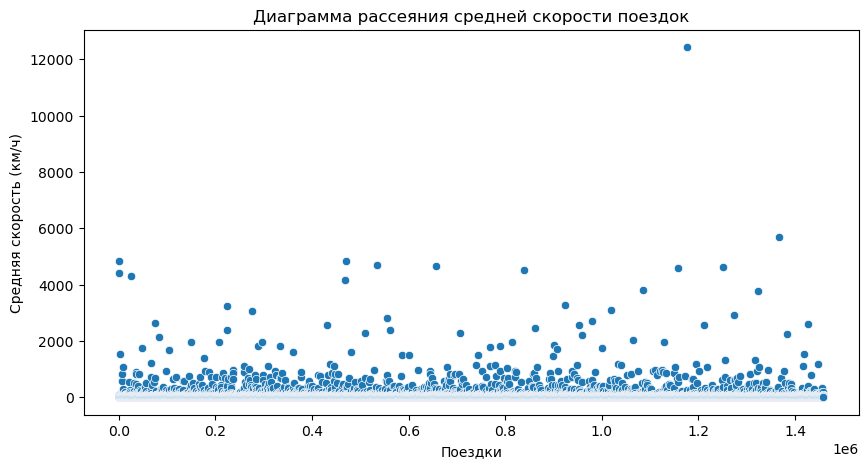

In [15]:
avg_speed = taxi_data['total_distance'] / taxi_data['trip_duration'] * 3.6
fig, ax = plt.subplots(figsize=(10, 5))
sns.scatterplot(x=avg_speed.index, y=avg_speed, ax=ax)
ax.set_xlabel('Поездки');
ax.set_ylabel('Средняя скорость (км/ч)');
ax.set_title('Диаграмма рассеяния средней скорости поездок');

Как раз отсюда мы видим, что у нас есть “поездки-телепортации”, для которых средняя скорость более 1000 км/ч. Даже есть такая, средняя скорость которой составляла более 12000 км/ч! 

Давайте условимся, что предельная средняя скорость, которую могут развивать таксисты будет 300 км/ч. 


### Задание 2.11.
Найдите поездки, длительность которых превышает 24 часа. И удалите их из набора данных.

а) Сколько выбросов по признаку длительности поездки вам удалось найти?

Найдите поездки, средняя скорость которых по кратчайшему пути превышает 300 км/ч и удалите их из данных. 

б) Сколько выбросов по признаку скорости вам удалось найти?

In [16]:
# Найдем выбросы по признаку длительности поездки свыше 24 часов
trip_ind = taxi_data[(taxi_data['trip_duration'] / 3600 ) > 24].index
# Найдем выбросы по признаку средней скорости свыше 300 км/ч
speed_ind = avg_speed[avg_speed > 300].index

# Удаляем найденные выбросы
taxi_data.drop(index=trip_ind, axis=0, inplace=True)
taxi_data.drop(index=speed_ind, axis=0, inplace=True)

# Выведем ответы на экран
print('Найдено и удалено выбросов по признаку длительности поездки свыше 24 часов:', len(trip_ind))
print('Найдено и удалено выбросов по признаку скорости поездки свыше 300 км/ч:', len(speed_ind))

del trip_ind, speed_ind # освободим память

Найдено и удалено выбросов по признаку длительности поездки свыше 24 часов: 4
Найдено и удалено выбросов по признаку скорости поездки свыше 300 км/ч: 407


## 3. Разведывательный анализ данных (EDA)

В этой части нашего проекта мы с вами:
* Исследуем сформированный набор данных; 
* Попробуем найти закономерности, позволяющие сформулировать предварительные гипотезы относительно того, какие факторы являются решающими в определении длительности поездки;
* Дополним наш анализ визуализациями, иллюстрирующими; исследование. Постарайтесь оформлять диаграммы с душой, а не «для галочки»: навыки визуализации полученных выводов обязательно пригодятся вам в будущем.


Начинаем с целевого признака. Забегая вперед, скажем, что основной метрикой качества решения поставленной задачи будет RMSLE - Root Mean Squared Log Error, которая вычисляется на основе целевой переменной в логарифмическом масштабе. В таком случае целесообразно сразу логарифмировать признак длительности поездки и рассматривать при анализе логарифм в качестве целевого признака:
$$trip\_duration\_log = log(trip\_duration+1),$$
где под символом log подразумевается натуральный логарифм.


In [17]:
taxi_data['trip_duration_log'] = np.log(taxi_data['trip_duration']+1)

### Задание 3.1.
Постройте гистограмму и коробчатую диаграмму длительности поездок в логарифмическом масштабе (trip_duration_log). 
Исходя из визуализации, сделайте предположение, является ли полученное распределение нормальным? 
Проверьте свою гипотезу с помощью теста Д’Агостино при уровне значимости $\alpha=0.05$. 

а) Чему равен вычисленный p-value? Ответ округлите до сотых.

б) Является ли распределение длительности поездок в логарифмическом масштабе нормальным?

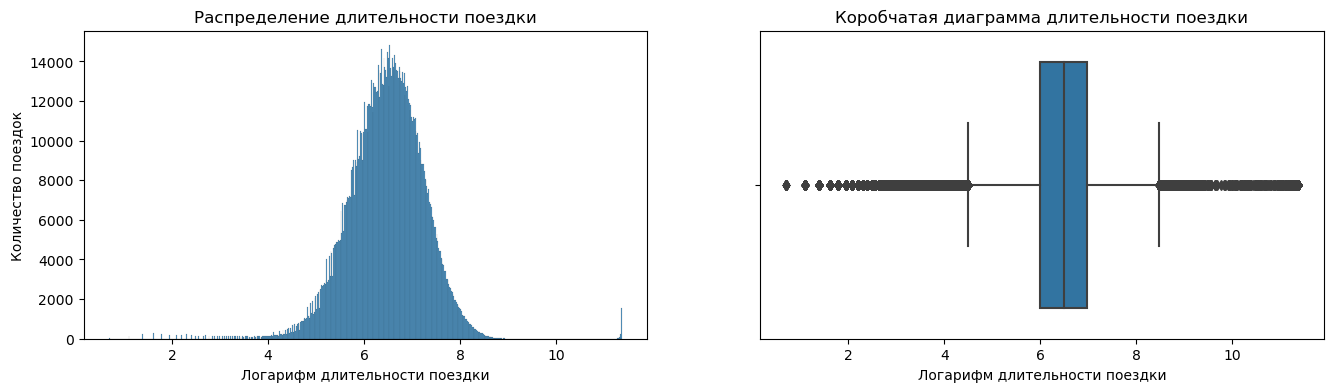

In [18]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(16, 4))

# Построим гистограмму
histplot = sns.histplot(
    data=taxi_data,
    x='trip_duration_log',
    ax=axes[0]
);
histplot.set_title('Распределение длительности поездки');
histplot.set_xlabel('Логарифм длительности поездки');
histplot.set_ylabel('Количество поездок');

# Построим коробчатую диаграмму
boxplot = sns.boxplot(
    data = taxi_data,
    x = 'trip_duration_log',
    ax = axes[1]
);
boxplot.set_title('Коробчатая диаграмма длительности поездки');
boxplot.set_xlabel('Логарифм длительности поездки');

> Исходя из диаграмм выше, можно предположить, что распределение признака длительности поездки в логарифмическом масштабе является нормальным. Проверим это с помощью теста Д'Агостино.

In [19]:
# Установим уровень значимости и подготовим сообщения о результатах
alpha = 0.05
H0 = 'Данные распределены нормально.'
Ha = 'Данные не распределены нормально (отвергаем гипотезу H0).'

# Проводим тест
_, p = stats.normaltest(taxi_data['trip_duration_log'])

# Выведем результаты теста на экран
print("Значение p-value в тесте Д'Агостино:", p)
if p > alpha/2:
    print(H0)
else:
    print(Ha)

Значение p-value в тесте Д'Агостино: 0.0
Данные не распределены нормально (отвергаем гипотезу H0).


> Тест Д'Агостино показал, однако, что данные о длительности поездок в логарифмическом масштабе не распределены нормально!  
> Очевидно, все дело в выбросах по краям распределения.  

### Задание 3.2.
Постройте визуализацию, которая позволит сравнить распределение длительности поездки в логарифмическом масштабе (trip_duration_log) в зависимости от таксопарка (vendor_id). 

Сравните два распределения между собой.

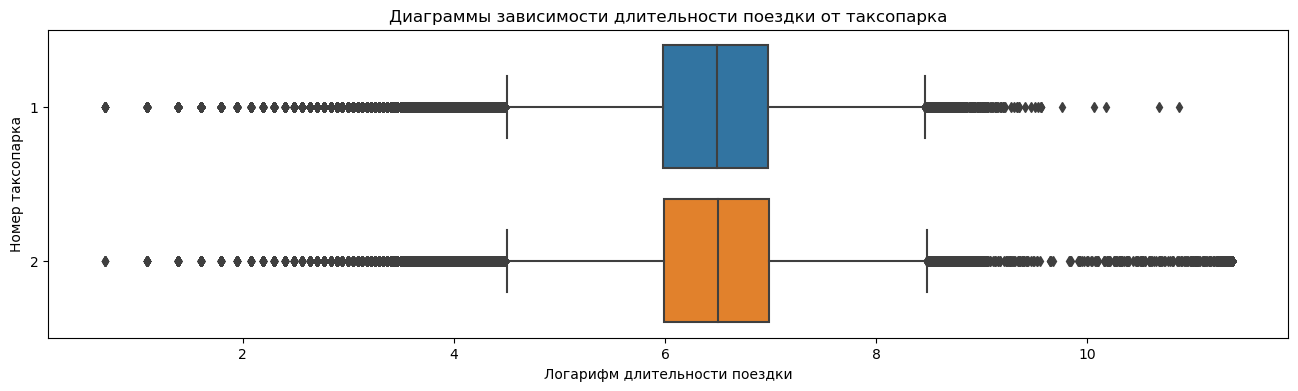

In [20]:
# Построим коробчатые диаграммы
fig = plt.figure(figsize=(16, 4))
boxplot = sns.boxplot(
    data=taxi_data,
    x='trip_duration_log',
    y='vendor_id',
    orient='h'
)
boxplot.set_title('Диаграммы зависимости длительности поездки от таксопарка');
boxplot.set_xlabel('Логарифм длительности поездки');
boxplot.set_ylabel('Номер таксопарка');

> Как видно, принадлежность машины к тому или иному таксопарку никак не влияет на длительность поездки (за исключением чуть меньшего количества выбросов у первого таксопарка).

### Задание 3.3.
Постройте визуализацию, которая позволит сравнить распределение длительности поездки в логарифмическом масштабе (trip_duration_log) в зависимости от признака отправки сообщения поставщику (store_and_fwd_flag). 

Сравните два распределения между собой.

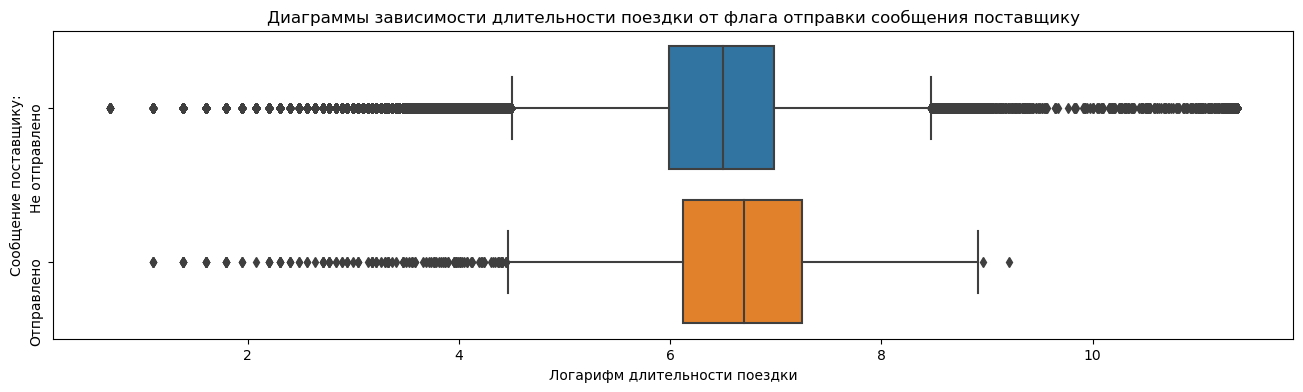

In [21]:
# Построим коробчатые диаграммы
fig = plt.figure(figsize=(16, 4))
boxplot = sns.boxplot(
    data=taxi_data,
    x='trip_duration_log',
    y='store_and_fwd_flag',
    orient='h'
)
boxplot.set_title('Диаграммы зависимости длительности поездки от флага отправки сообщения поставщику');
boxplot.set_xlabel('Логарифм длительности поездки');
boxplot.set_ylabel('Сообщение поставщику:');
boxplot.set_yticklabels(labels=['Не отправлено', 'Отправлено'], rotation=90);

> Распределения логарифма длительности поездок отличаются в зависимости от факта сохранения и отправки сообщения поставщику: наиболее длительные поездки совершались в тех случаях, когда сообщения о них не сохранялись и не пересылались поставщику.

### Задание 3.4.
Постройте две визуализации:
* Распределение количества поездок в зависимости от часа дня;
* Зависимость медианной длительности поездки от часа дня.

На основе построенных графиков ответьте на следующие вопросы:

а) В какое время суток такси заказывают реже всего?

б) В какое время суток наблюдается пик медианной длительности поездок?

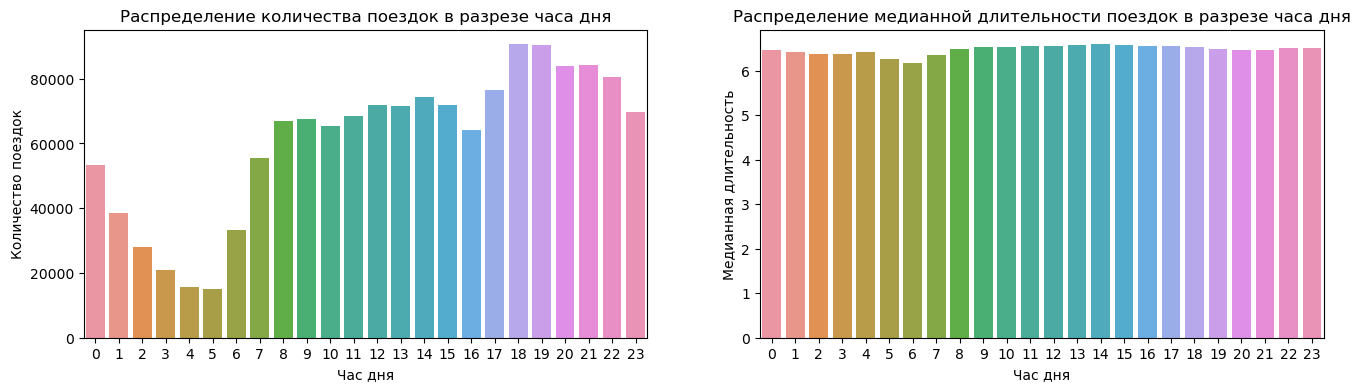

In [22]:
# Сгруппируем данные и вычислим искомые значения
hours_trips = taxi_data.groupby('pickup_hour')['trip_duration_log'].agg(['count', 'median'])

# Построим диаграммы распределения
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(16, 4))

barplot1 = sns.barplot(
    data=hours_trips,
    x=hours_trips.index,
    y='count',
    ax=axes[0]
);
barplot1.set_title('Распределение количества поездок в разрезе часа дня');
barplot1.set_xlabel('Час дня');
barplot1.set_ylabel('Количество поездок');

barplot2 = sns.barplot(
    data=hours_trips,
    x=hours_trips.index,
    y='median',
    ax=axes[1]
);
barplot2.set_title('Распределение медианной длительности поездок в разрезе часа дня');
barplot2.set_xlabel('Час дня');
barplot2.set_ylabel('Медианная длительность');

del hours_trips # очистим память

> Из первой диаграммы можем заключить, что реже всего заказывают такси в ночной период с 00:00 до 05:00.  
>
> На второй диаграмме видно, что пик медианной длительности приходится на дневной период: с 13:00 до 18:00.  

### Задание 3.5.
Постройте две визуализации:
* Распределение количества поездок в зависимости от дня недели;
*  Зависимость медианной длительности поездки от дня недели.

На основе построенных графиков ответьте на следующие вопросы:
а) В какой день недели совершается больше всего поездок?
б) В какой день недели медианная длительность поездок наименьшая?


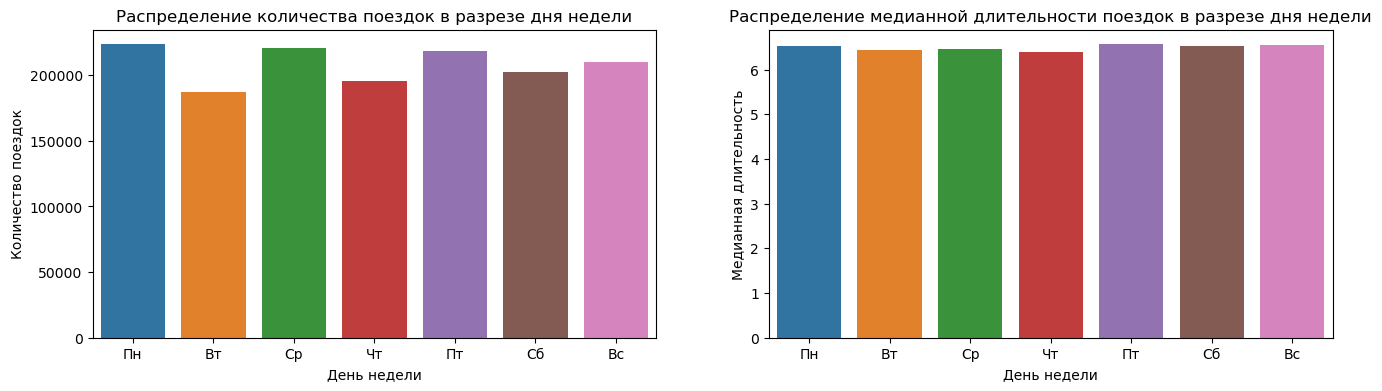

In [23]:
# Сгруппируем данные и вычислим искомые значения
days_trips = taxi_data.groupby('pickup_day_of_week')['trip_duration_log'].agg(['count', 'median'])
week_days = ['Пн', 'Вт', 'Ср', 'Чт', 'Пт', 'Сб', 'Вс']

# Построим диаграммы распределения
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(16, 4))

barplot1 = sns.barplot(
    data=days_trips,
    x=days_trips.index,
    y='count',
    ax=axes[0]
);
barplot1.set_title('Распределение количества поездок в разрезе дня недели');
barplot1.set_xlabel('День недели');
barplot1.set_ylabel('Количество поездок');
barplot1.set_xticklabels(labels=week_days);

barplot2 = sns.barplot(
    data=days_trips,
    x=days_trips.index,
    y='median',
    ax=axes[1]
);
barplot2.set_title('Распределение медианной длительности поездок в разрезе дня недели');
barplot2.set_xlabel('День недели');
barplot2.set_ylabel('Медианная длительность');
barplot2.set_xticklabels(labels=week_days);

del days_trips # очистим память

> Наибольшее число поездок совершается в пятницу.  
>
> А наименьшая медианная длительность поездок приходится на воскресенье.

### Задание 3.6.
Посмотрим на обе временные характеристики одновременно. 

Постройте сводную таблицу, по строкам которой отложены часы (pickup_hour), по столбцам - дни недели (pickup_day_of_week), а в ячейках - медианная длительность поездки (trip_duration). 

Визуализируйте полученную сводную таблицу с помощью тепловой карты (рекомендуемая палитра - coolwarm).

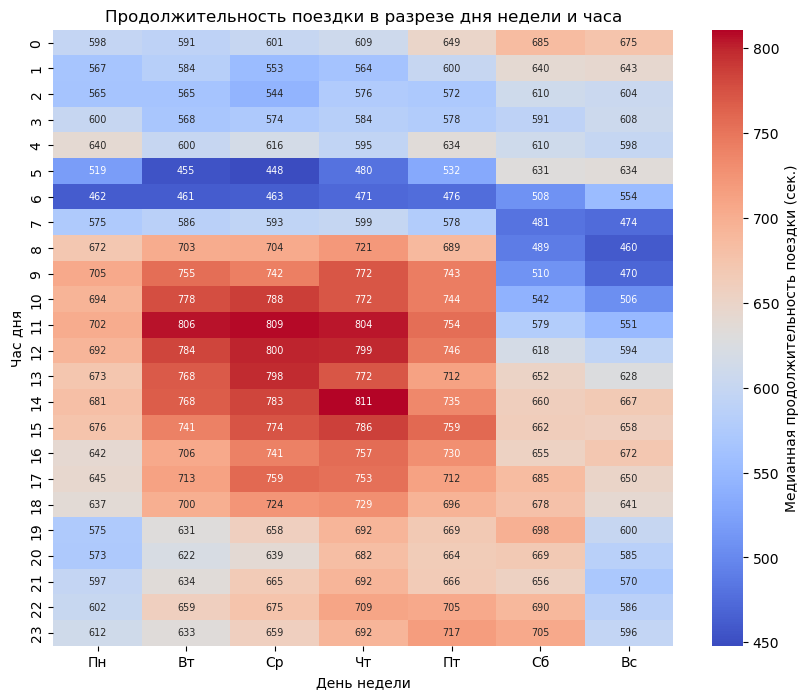

In [24]:
day_hour_dur = pd.pivot_table(
    data=taxi_data,
    index='pickup_hour',
    columns='pickup_day_of_week',
    values='trip_duration',
    aggfunc='median'
)

# Расположим дни в принятой последовательности
week = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
day_hour_dur = day_hour_dur[week]

# Построим тепловую карту
fig = plt.figure(figsize=(10, 8))

heatmap = sns.heatmap(
    data=day_hour_dur,
    cmap='coolwarm',
    cbar_kws={'label':'Медианная продолжительность поездки (сек.)'},
    annot = True,
    annot_kws={'fontsize':'x-small'},
    fmt = '.0f'
)

heatmap.set_title('Продолжительность поездки в разрезе дня недели и часа');
heatmap.set_ylabel('Час дня');
heatmap.set_xlabel('День недели');
heatmap.set_xticklabels(labels=week_days);

del day_hour_dur # очистим память

> Интересно отметить, что наибольшие медианные длительности поездок приходятся на будни со вторника по пятницу, на период с 8 до 16 часов. Видимо, данные поездки непосредственно связаны с работой.  
>
> Наименьшая длительность в будни фиксируется в период с 5 до 6 утра. При этом можно видеть, как это окно смещается к 6-10 часам в выходные, очевидно, из-за того, что люди до поздна проводят время в городе и поздно ночью разъежаются по домам.  

### Задание 3.7.
Постройте две диаграммы рассеяния (scatter-диаграммы):
* первая должна иллюстрировать географическое расположение точек начала поездок (pickup_longitude, pickup_latitude) 
* вторая - географическое расположение точек завершения поездок (dropoff_longitude, dropoff_latitude).

Для этого на диаграммах по оси абсцисс отложите широту (longitude), а по оси ординат - долготу (latitude). 
Включите в визуализацию только те точки, которые находятся в пределах Нью-Йорка - добавьте следующие ограничения на границы осей абсцисс и ординат:
 
city_long_border = (-74.03, -73.75)

city_lat_border = (40.63, 40.85)

Добавьте на диаграммы расцветку по десяти географическим кластерам (geo_cluster), которые мы сгенерировали ранее. 

**Рекомендация:** для наглядности уменьшите размер точек на диаграмме рассеяния.  


Количество кластеров, которые поместились на диаграмме: 8 из 10.


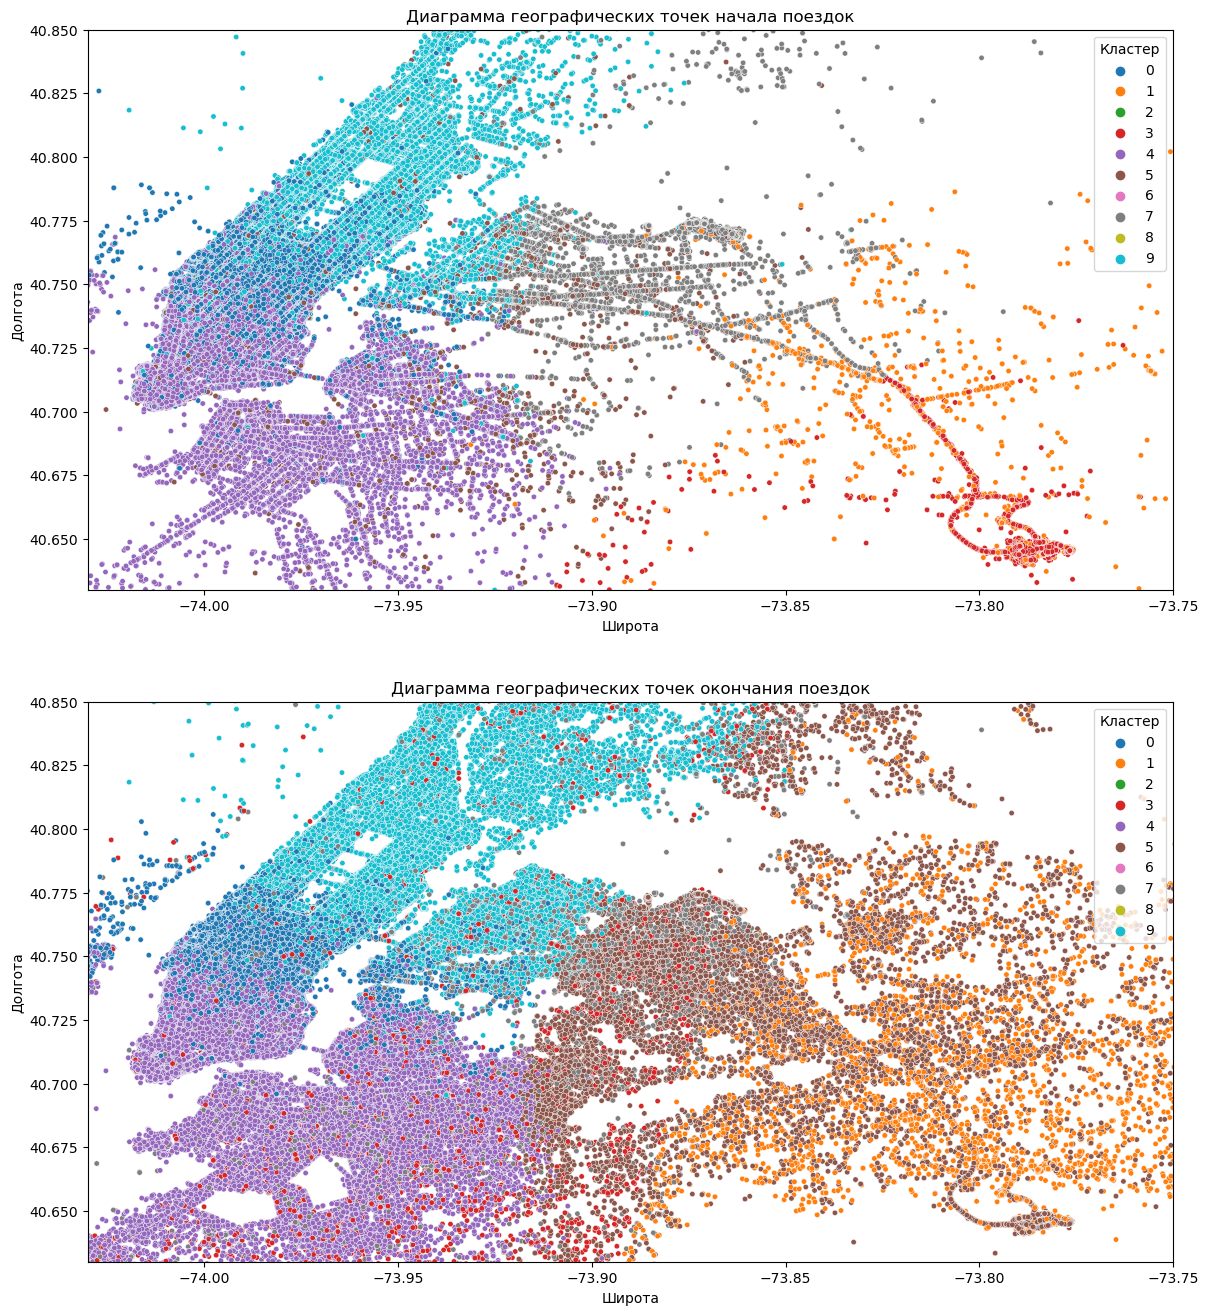

In [25]:
# Запишем в кортежи ограничения координат
city_long_border = (-74.03, -73.75)
city_lat_border = (40.63, 40.85)

# Зададим список параметов диаграмм для построения в цикле
params = [
    ['pickup_longitude', 'pickup_latitude', 'Диаграмма географических точек начала поездок'],
    ['dropoff_longitude', 'dropoff_latitude', 'Диаграмма географических точек окончания поездок']
]

# Построим обе диаграммы
fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(14, 16))
for i, param in enumerate(params):
    scatterplot = sns.scatterplot(
        data = taxi_data,
        x = param[0],
        y = param[1],
        hue = 'geo_cluster',
        s = 15,
        palette = 'tab10',
        legend = 'brief',
        ax=axes[i]
    );
    scatterplot.set_title(param[2]);
    scatterplot.set_xlabel('Широта');
    scatterplot.set_ylabel('Долгота');
    scatterplot.legend(title='Кластер', loc='upper right');
    scatterplot.set(xlim=city_long_border, ylim=city_lat_border);

# Ответим на вопрос задания на платформе: сколько из 10 кластеров видны на диаграммах
mask1 = taxi_data['pickup_longitude'] > city_long_border[0]
mask2 = taxi_data['pickup_longitude'] < city_long_border[1]
mask3 = taxi_data['pickup_latitude'] > city_lat_border[0]
mask4 = taxi_data['pickup_latitude'] < city_lat_border[1]
nclusters = taxi_data[mask1 & mask2 & mask3 & mask4]['geo_cluster'].nunique()
print(f'Количество кластеров, которые поместились на диаграмме: {nclusters} из 10.')

> На диаграммах отчетливо вырисовываются контуры Нью-Йорка, и можно видеть, что большая часть поездок начинается в деловых районах города. С окончанием поездок картина менее однозначная: огромное количество поездок заканчиваются, по-видимому, в жилых кварталах и пригороде.  
>  
> Можно предположить с одной стороны, что пространная география окончания поездок связана с их временем: люди пользуются такси, например, чтобы добраться из центра домой в поздний час, когда пробки уже незначительны. В то время как ехать утром на работу из спального райна в центр на такси - однозначно приведет к попаданию в пробки, из-за чего люди выбирают общественый транспорт.  
>  
> С другой стороны, офисные здания в центре обеспечивают высокую концентрацию людей, поэтому точки начала поездок часто совпадают, в то время как места проживания, куда люди отправляются после работы, рассосредоточены по большому пространству, что неизбежно ведет к большим вариациям точек окончания поездок.  
>  
> Отдельного внимания заслуживает контур лассо в правом нижнем углу и ведущая к нему дорога (наиболее отчетливо просматривающася на диаграмме начала поездок). Это район аэропорта Джона Ф. Кеннеди. По всей вероятности, многие прилетающие выбирают добираться до города на такси. А вот оказаться в пробке и опоздать на самолет - большой риск, поэтому точки окончания поездок вблизи аэропорта не сливаются в одну линию и соответствуют, скорее всего, часам, когда дороги свободны.  
>
> Стоит отменить, что в процессе работы автор решил воспользоваться библиотекой Plotly, графики которой позволили бы отлючать различные кластеры на диаграмме для того, чтобы лучше понимать их структуру. Однако построение таких интерактивных графиков увеличивало размер ноутбука до 100+ Мб, что неизбежно приводило к зависанию не только персонального компьютера, но и страницы на платформе kaggle. Причина - слишком большое количество данных (1,5 млн точек на диаграмме!). С учетом этого обстоятельства, выбор пришлось остановить на статичных диаграммах Seaborn.  

## 4. Отбор и преобразование признаков

Перед тем как перейти к построению модели, осталось сделать ещё несколько шагов.
* Следует помнить, что многие алгоритмы машинного обучения не могут обрабатывать категориальные признаки в их обычном виде. Поэтому нам необходимо их закодировать;
* Надо отобрать признаки, которые мы будем использовать для обучения модели;
*  Необходимо масштабировать и трансформировать некоторые признаки для того, чтобы улучшить сходимость моделей, в основе которых лежат численные методы.


In [26]:
print('Shape of data: {}'.format(taxi_data.shape))
print('Columns: {}'.format(taxi_data.columns))

Shape of data: (1458233, 27)
Columns: Index(['id', 'vendor_id', 'pickup_datetime', 'dropoff_datetime',
       'passenger_count', 'pickup_longitude', 'pickup_latitude',
       'dropoff_longitude', 'dropoff_latitude', 'store_and_fwd_flag',
       'trip_duration', 'pickup_date', 'pickup_hour', 'pickup_day_of_week',
       'pickup_holiday', 'total_distance', 'total_travel_time',
       'number_of_steps', 'haversine_distance', 'direction', 'geo_cluster',
       'temperature', 'visibility', 'wind speed', 'precip', 'events',
       'trip_duration_log'],
      dtype='object')


Для удобства работы сделаем копию исходной таблицы с поездками:

In [27]:
taxi_data.to_csv('/kaggle/working/eda_taxi_data.csv')

In [28]:
train_data = taxi_data.copy()
train_data.head()

,id,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,...,number_of_steps,haversine_distance,direction,geo_cluster,temperature,visibility,wind speed,precip,events,trip_duration_log
0,id2875421,2,2016-03-14 17:24:55,2016-03-14 17:32:30,1,-73.982155,40.767937,-73.964630,40.765602,N,...,5.0,1.498521,99.970196,9,4.4,8.0,27.8,0.3,None,6.122493
1,id2377394,1,2016-06-12 00:43:35,2016-06-12 00:54:38,1,-73.980415,40.738564,-73.999481,40.731152,N,...,6.0,1.805507,-117.153768,4,28.9,16.1,7.4,0.0,None,6.498282
2,id3858529,2,2016-01-19 11:35:24,2016-01-19 12:10:48,1,-73.979027,40.763939,-74.005333,40.710087,N,...,16.0,6.385098,-159.680165,4,-6.7,16.1,24.1,0.0,None,7.661527
3,id3504673,2,2016-04-06 19:32:31,2016-04-06 19:39:40,1,-74.010040,40.719971,-74.012268,40.706718,N,...,4.0,1.485498,-172.737700,4,7.2,16.1,25.9,0.0,None,6.063785
4,id2181028,2,2016-03-26 13:30:55,2016-03-26 13:38:10,1,-73.973053,40.793209,-73.972923,40.782520,N,...,5.0,1.188588,179.473585,9,9.4,16.1,9.3,0.0,None,6.077642


### Задание 4.1.
Сразу позаботимся об очевидных неинформативных и избыточных признаках. 

а) Какой из признаков является уникальным для каждой поездки и не несет полезной информации в определении ее продолжительности?

б) Утечка данных (data leak) - это…

в) Подумайте, наличие какого из признаков в обучающем наборе данных создает утечку данных?

г) Исключите выбранные в пунктах а) и в) признаки из исходной таблицы с данными. Сколько столбцов в таблице у вас осталось?


In [29]:
# Удалим уникальный признак id, а также, ведущий к утечке данных - dropoff_datetime
train_data.drop(['id', 'dropoff_datetime'], axis=1, inplace=True)
print(f'В таблице осталось {train_data.shape[1]} столбцов.')

В таблице осталось 25 столбцов.


Ранее мы извлекли всю необходимую для нас информацию из даты начала поездки, теперь мы можем избавиться от этих признаков, так как они нам больше не понадобятся:


In [30]:
train_data.drop(['pickup_datetime', 'pickup_date'], axis=1, inplace=True)
print('Shape of data:  {}'.format(train_data.shape))

Shape of data:  (1458233, 23)


### Задание 4.2.
Закодируйте признак vendor_id в таблице train_data таким образом, чтобы он был равен 1, если идентификатор таксопарка равен 0, и 1 в противном случае.

Закодируйте признак store_and_fwd_flag в таблице train_data таким образом, чтобы он был равен 0, если флаг выставлен в значение "N", и 0 в противном случае.

а) Рассчитайте среднее по закодированному столбцу vendor_id. Ответ приведите с точностью до сотых.

б) Рассчитайте среднее по закодированному столбцу store_and_fwd_flag. Ответ приведите с точностью до тысячных.



In [31]:
# Закодируем признаки вручную
train_data['vendor_id'] = train_data['vendor_id'].apply(lambda x: 0 if x == 1 else 1)
train_data['store_and_fwd_flag'] = train_data['store_and_fwd_flag'].apply(lambda x: 0 if x == 'N' else 1)

# Выведем ответы на вопросы задания
print('Среднее по столбцу vendor_id =', round(train_data.vendor_id.mean(),2))
print('Среднее по столбцу store_and_fwd_flag =', round(train_data.store_and_fwd_flag.mean(),3))

Среднее по столбцу vendor_id = 0.53
Среднее по столбцу store_and_fwd_flag = 0.006


### Задание 4.3.
Создайте таблицу data_onehot из закодированных однократным кодированием признаков pickup_day_of_week, geo_cluster и events в таблице train_data с помощью OneHotEndoder из библиотеки sklearn. Параметр drop выставите в значение 'first', чтобы удалять первый бинарный столбец, тем самым не создавая излишних признаков.

В результате работы OneHotEncoder вы получите безымянный numpy-массив, который нам будет необходимо преобразовать обратно в DataFrame, для более удобной работы в дальнейшем. Чтобы получить имена закодированных столбцов у объекта типа OneHotEncoder есть специальный метод get_feature_names_out(). Он возвращает список новых закодированных имен столбцов в формате <оригинальное имя столбца>_<имя категории>.

Пример использования:

``` python
# Получаем закодированные имена столбцов
column_names = one_hot_encoder.get_feature_names_out()
# Составляем DataFrame из закодированных признаков
data_onehot = pd.DataFrame(data_onehot, columns=column_names)
```

В этом псевдокоде:
* one_hot_encoder - объект класса OneHotEncoder
* data_onehot - numpy-массив, полученный в результате трансформации кодировщиком

В результате выполнения задания у вас должен быть образован DataFrame `data_onehot`, который содержит кодированные категориальные признаки pickup_day_of_week, geo_cluster и events. 


Сколько бинарных столбцов у вас получилось сгенерировать с помощью однократного кодирования?


In [32]:
columns_to_encode = ['pickup_day_of_week', 'geo_cluster', 'events']

# Создаем объект класса и обучаем его на выборке признаков
# Важно отметить, что с параметром drop='first будет потеряно по одному
# значению в каждом признаке - ценность от этого незначительная,
# но так требует автор задания...
one_hot_encoder = preprocessing.OneHotEncoder(drop='first', dtype=int)
one_hot_encoder.fit(train_data[columns_to_encode])

# Выполняем кодирование
data_onehot = one_hot_encoder.transform(train_data[columns_to_encode]).toarray()

# Получаем закодированные имена столбцов
column_names = one_hot_encoder.get_feature_names_out()

# Составляем DataFrame из закодированных признаков
data_onehot = pd.DataFrame(data_onehot, columns=column_names)

# Выведем результаты работы на экран
print(f'В результате кодирования получилось {data_onehot.shape[1]} бинарных столбцов.')

В результате кодирования получилось 18 бинарных столбцов.


Добавим полученную таблицу с закодированными признаками:

In [33]:
train_data = pd.concat(
    [train_data.reset_index(drop=True).drop(columns_to_encode, axis=1), data_onehot], 
    axis=1
)
print('Shape of data: {}'.format(train_data.shape))

Shape of data: (1458233, 38)


Теперь, когда категориальные признаки предобработаны, сформируем матрицу наблюдений X, вектор целевой переменной y и его логарифм y_log. В матрицу наблюдений войдут все столбцы из таблицы с поездками за исключением целевого признака trip_duration и его логарифмированной версии trip_duration_log:


In [34]:
X = train_data.drop(['trip_duration', 'trip_duration_log'], axis=1)
y = train_data['trip_duration']
y_log = train_data['trip_duration_log']

Все наши модели мы будем обучать на логарифмированной версии y_log. 

Выбранный тип валидации - hold-out. Разобьем выборку на обучающую и валидационную в соотношении 67/33:

In [35]:
X_train, X_valid, y_train_log, y_valid_log = model_selection.train_test_split(
    X, y_log, 
    test_size=0.33, 
    random_state=42
)

На данный момент у нас достаточно много признаков: скорее всего, не все из них будут важны. Давайте оставим лишь те, которые сильнее всего связаны с целевой переменной и точно будут вносить вклад в повышение качества модели.


### Задание 4.4.
С помощью SelectKBest отберите 25 признаков, наилучшим образом подходящих для предсказания целевой переменной в логарифмическом масштабе. Отбор реализуйте по обучающей выборке, используя параметр score_func = f_regression.

Укажите признаки, которые вошли в список отобранных


In [36]:
# Создаем объект класса SelectKBest
kbest = SelectKBest(score_func=f_regression, k=25)

# Подгоняем его под даные и получаем список лучших 25 признаков
kbest.fit(X_train, y_train_log)
kbest_columns = kbest.get_feature_names_out()

# Оставляем лучшие признаки в датафреймах
X_train = X_train[kbest_columns]
X_valid = X_valid[kbest_columns]

# Выведем ответ на вопрос задания на экран
print('Отобранные 25 признаков:', kbest_columns)

Отобранные 25 признаков: ['vendor_id' 'passenger_count' 'pickup_longitude' 'pickup_latitude'
 'dropoff_longitude' 'dropoff_latitude' 'store_and_fwd_flag' 'pickup_hour'
 'pickup_holiday' 'total_distance' 'total_travel_time' 'number_of_steps'
 'haversine_distance' 'temperature' 'pickup_day_of_week_Monday'
 'pickup_day_of_week_Saturday' 'pickup_day_of_week_Sunday'
 'pickup_day_of_week_Thursday' 'pickup_day_of_week_Tuesday'
 'pickup_day_of_week_Wednesday' 'geo_cluster_1' 'geo_cluster_3'
 'geo_cluster_5' 'geo_cluster_7' 'geo_cluster_9']


Так как мы будем использовать различные модели, в том числе внутри которых заложены численные методы оптимизации, то давайте заранее позаботимся о масштабировании факторов. 


### Задание 4.5.
Нормализуйте предикторы в обучающей и валидационной выборках с помощью MinMaxScaler из библиотеки sklearn. Помните, что обучение нормализатора производится на обучающей выборке, а трансформация на обучающей и валидационной!

Рассчитайте среднее арифметическое для первого предиктора (т. е. для первого столбца матрицы) из валидационной выборки. Ответ округлите до сотых.


In [37]:
# Создаем объект класса MinMaxScaler
scaler = preprocessing.MinMaxScaler()

# Подгоняем нормализатор под тренировочную выборку
scaler.fit(X_train)

# Нормализуем обе выборки и сразу преобразуем их в датафреймы
X_train_scaled = pd.DataFrame(scaler.transform(X_train), columns=kbest_columns)
X_valid_scaled = pd.DataFrame(scaler.transform(X_valid), columns=kbest_columns)

# Выведем ответ на вопрос задания
print('Среднее арифметическое первого предиктора валидационной выборки =',
      round(X_valid_scaled.iloc[:,0].mean(),2))

Среднее арифметическое первого предиктора валидационной выборки = 0.54


## 5. Решение задачи регрессии: линейная регрессия и деревья решений

Определим метрику, по которой мы будем измерять качество наших моделей. Мы будем следовать канонам исходного соревнования на Kaggle и в качестве метрики использовать RMSLE (Root Mean Squared Log Error), которая вычисляется как:
$$RMSLE = \sqrt{\frac{1}{n}\sum_{i=1}^n(log(y_i+1)-log(\hat{y_i}+1))^2},$$
где:
* $y_i$ - истинная длительность i-ой поездки на такси (trip_duration)
* $\hat{y_i}$- предсказанная моделью длительность i-ой поездки на такси

Заметим, что логарифмирование целевого признака мы уже провели заранее, поэтому нам будет достаточно вычислить метрику RMSE для модели, обученной прогнозировать длительность поездки такси в логарифмическом масштабе:
$$z_i=log(y_i+1),$$
$$RMSLE = \sqrt{\frac{1}{n}\sum_{i=1}^n(z_i-\hat{z_i})^2}=\sqrt{MSE(z_i,\hat{z_i})}$$ 



### Задание 5.1.
Постройте модель линейной регрессии на обучающей выборке (факторы должны быть нормализованы, целевую переменную используйте в логарифмическом масштабе). Все параметры оставьте по умолчанию.

Для полученной модели рассчитайте метрику RMSLE на тренировочной и валидационной выборках. Ответ округлите до сотых.


In [38]:
# Строим и обучаем модель линейной регрессии
lin_reg = linear_model.LinearRegression().fit(X_train_scaled, y_train_log)

# Выполняем предсказание
y_train_pred_log = lin_reg.predict(X_train_scaled)
y_valid_pred_log = lin_reg.predict(X_valid_scaled)

# Выведем значения метрик на экран
print('Метрика RMSLE для тренировочной выборки:',
      round(np.sqrt(metrics.mean_squared_error(y_train_log, y_train_pred_log)),2))
print('Метрика RMSLE для валидационной выборки:',
      round(np.sqrt(metrics.mean_squared_error(y_valid_log, y_valid_pred_log)),2))

Метрика RMSLE для тренировочной выборки: 0.54
Метрика RMSLE для валидационной выборки: 0.54


### Задание 5.2.
Сгенерируйте полиномиальные признаки 2-ой степени с помощью PolynomialFeatures из библиотеки sklearn. Параметр include_bias выставите в значение False.

Постройте модель полиномиальной регрессии 2-ой степени на обучающей выборке (факторы должны быть нормализованы, целевую переменную используйте в логарифмическом масштабе). Все параметры оставьте по умолчанию.

а) Для полученной модели рассчитайте метрику RMSLE на тренировочной и валидационной выборках. Ответ округлите до сотых.

б) Наблюдаются ли у вашей модели признаки переобучения?


In [39]:
# Создаем объект класса PolynomialFeatures
poly = preprocessing.PolynomialFeatures(degree=2, include_bias=False)

# Генерируем полиномиальные признаки
X_train_scaled_poly = poly.fit_transform(X_train_scaled)
X_valid_scaled_poly = poly.transform(X_valid_scaled)

# Строим и обучаем модель полиноминальной регрессии
poly_reg = linear_model.LinearRegression().fit(X_train_scaled_poly, y_train_log)

# Выполняем предсказание
y_train_pred_log_poly = poly_reg.predict(X_train_scaled_poly)
y_valid_pred_log_poly = poly_reg.predict(X_valid_scaled_poly)

# Выведем значения метрик на экран
print('Метрика RMSLE для тренировочной выборки:',
      round(np.sqrt(metrics.mean_squared_error(y_train_log, y_train_pred_log_poly)),2))
print('Метрика RMSLE для валидационной выборки:',
      round(np.sqrt(metrics.mean_squared_error(y_valid_log, y_valid_pred_log_poly)),2))

Метрика RMSLE для тренировочной выборки: 0.47
Метрика RMSLE для валидационной выборки: 0.7


> При использовании модели полиномиальной регрессии наблюдается переобучение модели: значение метрики на тренировочной выборке снизилось (модель сильнее подстраивается под тренировочную выборку), а на валидационной выросло (модель плохо уловила зависимости в данных).

### Задание 5.3.
Постройте модель полиномиальной регрессии 2-ой степени с L2-регуляризацией (регуляризация по Тихонову) на обучающей выборке  (факторы должны быть нормализованы, целевую переменную используйте в логарифмическом масштабе). Коэффициент регуляризации $\alpha$ установите равным 1, остальные параметры оставьте по умолчанию.

Для полученной модели рассчитайте метрику RMSLE на тренировочной и валидационной выборках. Ответ округлите до сотых.


In [40]:
# Создаём объект класса линейной регрессии с L2-регуляризацией
ridge_poly_reg = linear_model.Ridge(alpha=1)

# Обучаем модель
ridge_poly_reg.fit(X_train_scaled_poly, y_train_log)

# Делаем предсказание для обеих выборок
y_train_pred_log_poly = ridge_poly_reg.predict(X_train_scaled_poly)
y_valid_pred_log_poly = ridge_poly_reg.predict(X_valid_scaled_poly)

# Выведем значения метрик на экран
print('Метрика RMSLE для тренировочной выборки:',
      round(np.sqrt(metrics.mean_squared_error(y_train_log, y_train_pred_log_poly)),2))
print('Метрика RMSLE для валидационной выборки:',
      round(np.sqrt(metrics.mean_squared_error(y_valid_log, y_valid_pred_log_poly)),2))

Метрика RMSLE для тренировочной выборки: 0.48
Метрика RMSLE для валидационной выборки: 0.48


### Задание 5.4.
Постройте модель дерева решений (DecisionTreeRegressor) на обучающей выборке (факторы должны быть нормализованы, целевую переменную используйте в логарифмическом масштабе). Все параметры оставьте по умолчанию. 

а) Для полученной модели рассчитайте метрику RMSLE на тренировочной и валидационной выборках. Ответ округлите до сотых.

б) Наблюдаются ли у вашей модели признаки переобучения?


In [41]:
# Строим и обучаем модель дерева решений
tree_reg = tree.DecisionTreeRegressor(random_state=42).fit(X_train_scaled, y_train_log)

# Выполняем предсказание
y_train_pred_log = tree_reg.predict(X_train_scaled)
y_valid_pred_log = tree_reg.predict(X_valid_scaled)

# Выведем значения метрик на экран
print('Метрика RMSLE для тренировочной выборки:',
      round(np.sqrt(metrics.mean_squared_error(y_train_log, y_train_pred_log)),2))
print('Метрика RMSLE для валидационной выборки:',
      round(np.sqrt(metrics.mean_squared_error(y_valid_log, y_valid_pred_log)),2))

Метрика RMSLE для тренировочной выборки: 0.0
Метрика RMSLE для валидационной выборки: 0.57


> И вновь мы видим признаки переобучения модели: метрика на тренировочной выборке равна нулю (то есть модель не ошибается), а на валидационной - достаточно высока. Таким образом, модель выучила тренировочный набор, но не научилась предсказывать целевой признак на валидационном.

### Задание 5.5.
Переберите все возможные варианты глубины дерева решений в диапазоне от 7 до 20:

max_depths = range(7, 20)

Постройте линейные графики изменения метрики RMSE на тренировочной и валидационной выборках в зависимости от значения параметра глубины дерева решений. 

а) Найдите оптимальное значение максимальной глубины дерева, для которой будет наблюдаться минимальное значение RMSLE на обучающей выборке, но при этом еще не будет наблюдаться переобучение (валидационная кривая еще не начинает возрастать).

б) Чему равно значение метрик RMSLE на тренировочной и валидационной выборках для дерева решений с выбранной оптимальной глубиной? Ответ округлите до сотых.


При оптимальной глубине дерева, равной 12, значение метрики RMSLE      
на тренировочной выборке равно 0.41, на валидационной - 0.43.


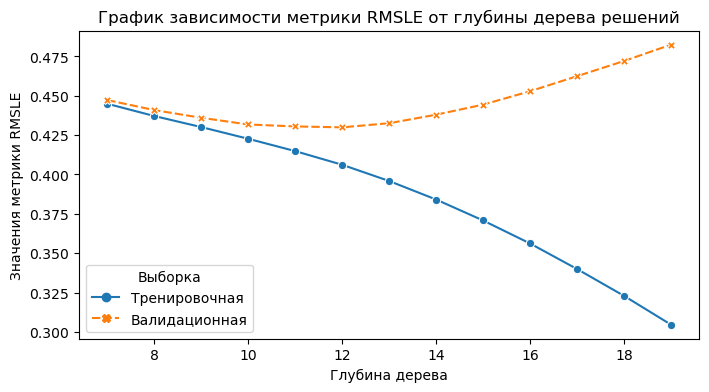

In [62]:
# Подготовим списки с глубиной дерева и для значений метрики
depths = list(np.arange(7, 20))
train_score = []
valid_score = []

# Обучим модель с каждым значением глубины дерева и сохраним результаты
for d in depths:
    # Строим и обучаем модель дерева решений
    tree_reg = tree.DecisionTreeRegressor(
        max_depth = d,
        random_state = 42)

    # Обучаем модель
    tree_reg.fit(X_train_scaled, y_train_log)

    # Выполняем предсказание
    y_train_pred_log = tree_reg.predict(X_train_scaled)
    y_valid_pred_log = tree_reg.predict(X_valid_scaled)

    # Добавим значения метрик в списки
    train_score.append(np.sqrt(metrics.mean_squared_error(y_train_log, y_train_pred_log)))
    valid_score.append(np.sqrt(metrics.mean_squared_error(y_valid_log, y_valid_pred_log)))

    
# Преобразуем получившиеся списки в датафрейм
rmsle_df = pd.DataFrame(
    data = {'Тренировочная': train_score,
            'Валидационная': valid_score},
    index = depths)

# Построим линейный график зависимости
fig = plt.figure(figsize=(8, 4))
lineplot = sns.lineplot(
    data = rmsle_df,
    dashes = True,
    markers = True
);
lineplot.set_title('График зависимости метрики RMSLE от глубины дерева решений');
lineplot.set_ylabel('Значения метрики RMSLE');
lineplot.set_xlabel('Глубина дерева');
lineplot.legend(title='Выборка');


# Ответим на вопрос задания
opt_depth = 12 # задаем оптимальную глубину, исходя из графика
# Определяем значение метрики для тренировочной выборки на этой глубине
t_s_opt = round(train_score[depths.index(opt_depth)],2)
# Определяем значение метрики для валидационной выборки на этой глубине
v_s_opt = round(valid_score[depths.index(opt_depth)],2)

#Выведем ответ на экран
print('При оптимальной глубине дерева, равной {0}, значение метрики RMSLE\
      \nна тренировочной выборке равно {1}, на валидационной - {2}.'.\
      format(opt_depth, t_s_opt, v_s_opt))

> Как следует из графика, оптимальное значение глубины дерева решений, при котором мы получаем минимальное значение метрики RMSLE на тренировочной выборке (0.41) до того, как значение метрики на валидационной выборке начнет расти (0.43), равно 12. 

## 6. Решение задачи регрессии: ансамблевые методы и построение прогноза

Переходим к тяжелой артиллерии: ансамблевым алгоритмам. 

### Задание 6.1.

Постройте модель случайного леса на обучающей выборке (факторы должны быть нормализованы, целевую переменную используйте в логарифмическом масштабе). В качестве гиперпараметров укажите следующие:
* n_estimators=200,
* max_depth=12,
* criterion='squared_error',
* min_samples_split=20,
* random_state=42

Для полученной модели рассчитайте метрику RMSLE на тренировочной и валидационной выборках. Ответ округлите до сотых.


In [43]:
# Строим модель случайного леса
for_reg = ensemble.RandomForestRegressor(
    n_estimators=200,
    max_depth=12,
    criterion='squared_error',
    min_samples_split=20,
    random_state=42,
    verbose=1
)

# Обучаем модель
for_reg.fit(X_train_scaled, y_train_log)

# Выполняем предсказание
y_train_pred_log_f_r = for_reg.predict(X_train_scaled)
y_valid_pred_log_f_r = for_reg.predict(X_valid_scaled)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 200 out of 200 | elapsed: 28.9min finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 200 out of 200 | elapsed:   19.9s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 200 out of 200 | elapsed:    9.8s finished


In [44]:
# Выведем значения метрик на экран
print('Метрика RMSLE для тренировочной выборки:',
      round(np.sqrt(metrics.mean_squared_error(y_train_log, y_train_pred_log_f_r)),2))
print('Метрика RMSLE для валидационной выборки:',
      round(np.sqrt(metrics.mean_squared_error(y_valid_log, y_valid_pred_log_f_r)),2))

Метрика RMSLE для тренировочной выборки: 0.4
Метрика RMSLE для валидационной выборки: 0.41


### Задание 6.2.
Постройте модель градиентного бустинга над деревьями решений (GradientBoostingRegressor) на обучающей выборке (факторы должны быть нормализованы, целевую переменную используйте в логарифмическом масштабе). В качестве гиперпараметров укажите следующие:
* learning_rate=0.5,
* n_estimators=100,
* max_depth=6, 
* min_samples_split=30,
* random_state=42

Для полученной модели рассчитайте метрику RMSLE на тренировочной и валидационной выборках. Ответ округлите до сотых.


In [45]:
# Строим модель градиентного бустинга
boo_reg = ensemble.GradientBoostingRegressor(
    learning_rate=0.5,
    n_estimators=100,
    max_depth=6, 
    min_samples_split=30,
    random_state=42,
    verbose=1
)

# Обучаем модель
boo_reg.fit(X_train_scaled, y_train_log)

# Выполняем предсказание
y_train_pred_log = boo_reg.predict(X_train_scaled)
y_valid_pred_log = boo_reg.predict(X_valid_scaled)

# Выведем значения метрик на экран
print('Метрика RMSLE для тренировочной выборки:',
      round(np.sqrt(metrics.mean_squared_error(y_train_log, y_train_pred_log)),2))
print('Метрика RMSLE для валидационной выборки:',
      round(np.sqrt(metrics.mean_squared_error(y_valid_log, y_valid_pred_log)),2))

      Iter       Train Loss   Remaining Time 
         1           0.3110           12.17m
         2           0.2247           12.00m
         3           0.1987           11.93m
         4           0.1875           11.80m
         5           0.1821           11.70m
         6           0.1789           11.56m
         7           0.1742           11.42m
         8           0.1721           11.30m
         9           0.1705           11.16m
        10           0.1694           11.04m
        20           0.1585            9.75m
        30           0.1532            8.50m
        40           0.1500            7.25m
        50           0.1468            6.04m
        60           0.1439            4.83m
        70           0.1421            3.61m
        80           0.1402            2.41m
        90           0.1383            1.20m
       100           0.1371            0.00s
Метрика RMSLE для тренировочной выборки: 0.37
Метрика RMSLE для валидационной выборки: 0.39


### Задание 6.3.
Какая из построенных вами моделей показала наилучший результат (наименьшее значение RMSLE на валидационной выборке)?
* Линейная регрессия
* Полиномиальная регрессия 2ой степени
* Дерево решений
* Случайный лес
* Градиентный бустинг над деревьями решений


| Модель | Значение RMSLE |
|---|---:|
| Линейная регрессия | 0.54 |
| Полиномиальная регрессия 2ой степени | 0.70 |
| Полиномиальная регрессия 2-ой степени с L2-регуляризацией | 0.48 |
| Дерево решений (с глубиной 11) | 0.43 |
| Случайный лес | 0.41 |
| Градиентный бустинг над деревьями решений | 0.39 |

### Задание 6.4.
Постройте столбчатую диаграмму коэффициентов значимости каждого из факторов.

Укажите топ-3 наиболее значимых для предсказания целевого признака - длительности поездки в логарифмическом масштабе - факторов.


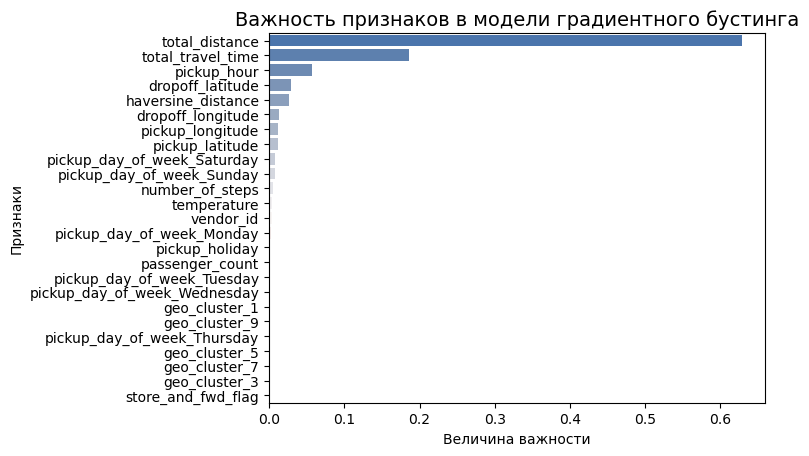

In [46]:
# Преобразуем массив важности признаков в градиентном бустинге в объект Series
gb_feat = pd.Series(boo_reg.feature_importances_,
                    index=X_train_scaled.columns).sort_values(ascending=False)

# Построим диаграмму, иллюстрирующую важность признаков в модели
barplot = sns.barplot(
    data = gb_feat.to_frame(name='importance').reset_index(),
    x = 'importance',
    y = 'index',
    orient = 'h',
    palette = 'vlag'
);

barplot.set_title('Важность признаков в модели градиентного бустинга', fontsize = 14);
barplot.set_xlabel('Величина важности');
barplot.set_ylabel('Признаки');

> Наиболее значимыми факторами в модели градиентного бустинга для целевого признака длительности поездки в логарифмическом масштабе оказались: total_distance, total_travel_time и pickup_hour.  

### Задание 6.5.
Для лучшей из построенных моделей рассчитайте медианную абсолютную ошибку (MeAE - в sklearn функция median_absolute_error) предсказания длительности поездки такси на валидационной выборке:
$$ MeAE = median(|y_i-\hat{y_i}|)$$

Значение метрики MeAE переведите в минуты и округлите до десятых.


In [47]:
# Переведем значения целевого признака из логарифмического масштаба обратно
y_valid = np.exp(y_valid_log) - 1
y_valid_pred = np.exp(y_valid_pred_log) - 1

#  Рассчитаем медианную абсолютную ошибку в минутах
meae = round(metrics.median_absolute_error(y_valid, y_valid_pred) / 60, 1)

# Выведем ответ на экран
print(f'Медианная абсолютная ошибка предсказания времени поездки составила {meae} минуты.')

Медианная абсолютная ошибка предсказания времени поездки составила 1.8 минуты.


Финальный шаг - сделать submit -  предсказание для отложенного тестового набора данных. 

Прочитаем тестовые данные и заранее выделим столбец с идентификаторами поездок из тестового набора данных. Он нам еще пригодится:


In [48]:
test_data = pd.read_csv(DATA_DIR+"nyc-taxi-trip-duration/test.zip")
osrm_data_test = pd.read_csv(DATA_DIR+"osrm-data-test/Project5_osrm_data_test.csv")

test_id = test_data['id']

Перед созданием прогноза для тестовой выборки необходимо произвести все манипуляции с данными, которые мы производили с тренировочной выборкой, а именно:
* Перевести признак pickup_datetime в формат datetime;
* Добавить новые признаки (временные, географические, погодные и другие факторы);
* Произвести очистку данных от пропусков;
* Произвести кодировку категориальных признаков:
    * Закодировать бинарные признаки;
    * Закодировать номинальные признаки с помощью обученного на тренировочной выборке OneHotEncoder’а;
* Сформировать матрицу наблюдений, оставив в таблице только те признаки, которые были отобраны с помощью SelectKBest;
* Нормализовать данные с помощью обученного на тренировочной выборке MinMaxScaler’а.


In [49]:
# Подготавливаем тестовую выборку к подаче на вход модели градиентного бустинга
test_data['pickup_datetime'] = pd.to_datetime(test_data['pickup_datetime'],
                                              format='%Y-%m-%d %H:%M:%S')
test_data = add_datetime_features(test_data)
test_data = add_holiday_features(test_data, holiday_data)
test_data = add_osrm_features(test_data, osrm_data_test)
test_data = add_geographical_features(test_data)
test_data = add_cluster_features(test_data, kmeans)
test_data = add_weather_features(test_data, weather_data)
test_data = fill_null_weather_data(test_data)

test_data['vendor_id'] = test_data['vendor_id'].apply(lambda x: 0 if x == 1 else 1)
test_data['store_and_fwd_flag'] = test_data['store_and_fwd_flag'].apply(lambda x: 0 if x == 'N' else 1)


test_data_onehot = one_hot_encoder.fit_transform(test_data[columns_to_encode]).toarray()
column_names = one_hot_encoder.get_feature_names_out(columns_to_encode)
test_data_onehot = pd.DataFrame(test_data_onehot, columns=column_names)

test_data = pd.concat(
    [test_data.reset_index(drop=True).drop(columns_to_encode, axis=1), test_data_onehot], 
    axis=1
)
X_test = test_data[kbest_columns]
X_test_scaled = pd.DataFrame(scaler.transform(X_test), columns=kbest_columns)

print('Shape of data: {}'.format(X_test.shape))

Shape of data: (625134, 25)


Только после выполнения всех этих шагов можно сделать предсказание длительности поездки для тестовой выборки. Не забудьте перевести предсказания из логарифмического масштаба в истинный, используя формулу:
$$y_i=exp(z_i)-1$$

После того, как вы сформируете предсказание длительности поездок на тестовой выборке вам необходимо будет создать submission-файл в формате csv, отправить его на платформу Kaggle и посмотреть на результирующее значение метрики RMSLE на тестовой выборке.  

In [50]:
# Выполняем предсказание
y_test_pred_log = boo_reg.predict(X_test_scaled)

# Переведем значение предсказания из логарифмического масштаба обратно
y_test_pred = np.exp(y_test_pred_log) - 1

# Заполняем submission-файл и сохраняем его
submission = pd.DataFrame({'id': test_id, 'trip_duration': y_test_pred})
submission.to_csv('/kaggle/working/submission_gb.csv', index=False)

# Посмотрим на структуру файла
submission

,id,trip_duration
0,id3004672,903.102542
1,id3505355,516.824939
2,id1217141,408.435989
3,id2150126,1026.909929
4,id1598245,251.341616
...,...,...
625129,id3008929,360.028686
625130,id3700764,1281.342243
625131,id2568735,1668.590098
625132,id1384355,1934.469591


 > В результате загрузки решения в соревнование получен следующий рейтинг:  
 >- Public score: 0.40549,  
 >- Private score: 0.40748.  

### **В качестве бонуса**

В завершение по ансамблевым мы предлагаем вам попробовать улучшить свое предсказание, воспользовавшись моделью экстремального градиентного бустинга (XGBoost) из библиотеки xgboost.

**XGBoost** - современная модель машинного обучения, которая является продолжением идеи градиентного бустинга Фридмана. У нее есть несколько преимуществ по сравнению с классической моделью градиентного бустинга из библиотеки sklearn: повышенная производительность путем параллелизации процесса обучения, повышенное качество решения за счет усовершенствования алгоритма бустинга, меньшая склонность к переобучению и широкий функционал возможности управления параметрами модели.


Для ее использования необходимо для начала установить пакет xgboost:

In [51]:
!pip install xgboost

После чего модуль можно импортировать:

In [52]:
import xgboost as xgb

Перед обучением модели необходимо перевести наборы данных в тип данных xgboost.DMatrix:

In [53]:
# Создание матриц наблюдений в формате DMatrix
dtrain = xgb.DMatrix(X_train_scaled, label=y_train_log, feature_names=kbest_columns)
dvalid = xgb.DMatrix(X_valid_scaled, label=y_valid_log, feature_names=kbest_columns)
dtest = xgb.DMatrix(X_test_scaled, feature_names=kbest_columns)

Обучение модели XGBoost происходит с помощью метода train, в который необходимо передать параметры модели, набор данных, количество базовых моделей в ансамбле, а также дополнительные параметры:


In [54]:
# Гиперпараметры модели
xgb_pars = {'min_child_weight': 20, 'eta': 0.1, 'colsample_bytree': 0.9, 
            'max_depth': 6, 'subsample': 0.9, 'lambda': 1, 'nthread': -1, 
            'booster' : 'gbtree', 'eval_metric': 'rmse', 'objective': 'reg:squarederror'
           }
# Тренировочная и валидационная выборка
watchlist = [(dtrain, 'train'), (dvalid, 'valid')]
# Обучаем модель XGBoost
model = xgb.train(
    params=xgb_pars, #гиперпараметры модели
    dtrain=dtrain, #обучающая выборка
    num_boost_round=300, #количество моделей в ансамбле
    evals=watchlist, #выборки, на которых считается матрица
    early_stopping_rounds=20, #раняя остановка
    maximize=False, #смена поиска максимума на минимум
    verbose_eval=10 #шаг, через который происходит отображение метрик
)

[0]	train-rmse:5.42222	valid-rmse:5.42195
[10]	train-rmse:1.93569	valid-rmse:1.93563
[20]	train-rmse:0.78551	valid-rmse:0.78635
[30]	train-rmse:0.47924	valid-rmse:0.48127
[40]	train-rmse:0.42057	valid-rmse:0.42325
[50]	train-rmse:0.40874	valid-rmse:0.41188
[60]	train-rmse:0.40423	valid-rmse:0.40773
[70]	train-rmse:0.40110	valid-rmse:0.40502
[80]	train-rmse:0.39888	valid-rmse:0.40310
[90]	train-rmse:0.39739	valid-rmse:0.40183
[100]	train-rmse:0.39571	valid-rmse:0.40040
[110]	train-rmse:0.39416	valid-rmse:0.39911
[120]	train-rmse:0.39324	valid-rmse:0.39856
[130]	train-rmse:0.39188	valid-rmse:0.39752
[140]	train-rmse:0.39080	valid-rmse:0.39677
[150]	train-rmse:0.38992	valid-rmse:0.39616
[160]	train-rmse:0.38925	valid-rmse:0.39570
[170]	train-rmse:0.38854	valid-rmse:0.39529
[180]	train-rmse:0.38793	valid-rmse:0.39500
[190]	train-rmse:0.38720	valid-rmse:0.39469
[200]	train-rmse:0.38608	valid-rmse:0.39387
[210]	train-rmse:0.38533	valid-rmse:0.39352
[220]	train-rmse:0.38464	valid-rmse:0.39326

Предсказать целевой признак на новых данных можно с помощью метода predict():

In [55]:
#Делаем предсказание на тестовом наборе данных
y_test_predict = np.exp(model.predict(dtest)) - 1
print('Modeling RMSLE %.5f' % model.best_score)

Modeling RMSLE 0.39107


In [56]:
# Заполняем submission-файл и сохраняем его
submission_xgb = pd.DataFrame({'id': test_id, 'trip_duration': y_test_predict})
submission_xgb.to_csv('/kaggle/working/submission_xgb.csv', index=False)

 > В результате загрузки решения XGBoost в соревнование получен следующий рейтинг:  
 >- Public score: 0.39933 (примерно 471 место),  
 >- Private score: 0.40185. 
 >  
 > Результаты, определенно, лучше, чем при использовании модели градиентного бустинга.

Также как и все модели, основанные на использовании деревьев решений в качестве базовых моделей, XGBoost имеет возможность определения коэффициентов важности факторов. Более того, в библиотеку встроена возможность визуализации важность факторов в виде столбчатой диаграммы. За эту возможность отвечает функция plot_importance():


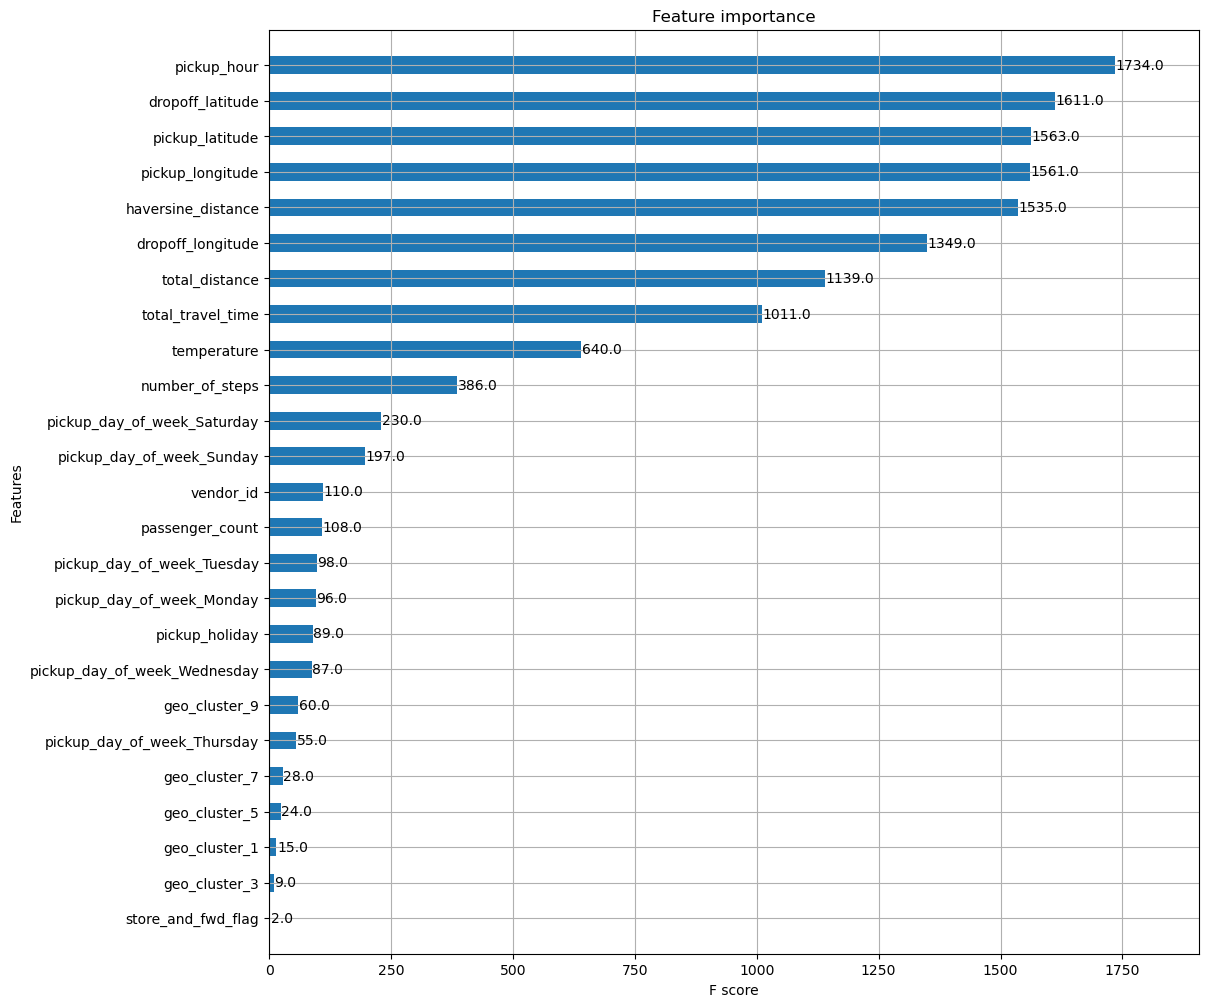

In [59]:
fig, ax = plt.subplots(figsize = (12,12))
xgb.plot_importance(model, ax = ax, height=0.5);

> Модель, постоенная с помощью библиотеки XGBoost продемонстрировала лучшее значение метрики RMSLE, чем GradientBostingRegressor, и позволила улушить результат на странице соревнования. 
> Кроме этого, данная модель иначе распределила признаки датасета по их важности. 
> Таким образом библиотека XGBoost заслуживает применения в последующих задачах.  

## Общий вывод по проекту

1. В ходе работы над проектом была **решена бизнес-задача - определены характеристики и спрогнозирована длительность поездки на такси**.  

2. Также была **решена и техническая задача области Data Science - построение модели машинного обучения, которая** на основе предложенных характеристик предсказывает числовой признак - время поездки такси, то есть **решает задачу регрессии**.  

3. Мы достигли всех поставленных целей: отобрали признаки из нескольких источников, спроектировали новые, отобрали наиболее значимые и подготовили данные для подачи на вход модели; обучили несколько моделей и выбрали наилучную по заданной метрике; наконец сделали предсказание и загрузили результаты на платформу kaggle. 

4. Данный проект позволил улучшить навыки работы на каждом этапе DS-задач.  
___